This notebook was used to produce Figure 1 of
>Anton Osokin, Anatole Chessel, Rafael E. Carazo Salas, Federico Vaggi<br>
GANs for Biological Image Synthesis<br>
In ICCV, 2017

In [1]:
import sys, os
import math
import numpy as np
from PIL import Image
import pylab as plt

import torch
from torch.autograd import Variable
import torchvision.utils as vutils

sys.path.insert(0, '../../code')
import dcgan_starshaped
from utils import pad_channels
from custom_dataloaders import read_image_for_pytorch

%matplotlib inline

In [2]:
# setup the network
network_path = '../../models/size-48-80_6class_wgangp-star-shaped-adam/netG_iter_50000.pth'
image_height = 48
image_width = 80
nz = 100
nc = 2
ngf = 64
n_classes= 6
red_portion = 0.5
    
netG = dcgan_starshaped.DCGAN_G_starShaped((image_height, image_width), nz, nc, ngf,
                                           n_classes, red_portion=red_portion)
netG.load_state_dict(torch.load(network_path))
print(netG)
netG.eval()

DCGAN_G_starShaped (
  (main): ModuleList (
    (0): CnvTranspose2d_starShape (
      (convt_red): ConvTranspose2d(50, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
      (batchnorm_red): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (convt_green): ModuleList (
        (0): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (1): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (2): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (3): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (4): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (5): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
      )
      (batchnorm_green): ModuleList (
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (2): BatchN

DCGAN_G_starShaped (
  (main): ModuleList (
    (0): CnvTranspose2d_starShape (
      (convt_red): ConvTranspose2d(50, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
      (batchnorm_red): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (convt_green): ModuleList (
        (0): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (1): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (2): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (3): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (4): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
        (5): ConvTranspose2d(100, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
      )
      (batchnorm_green): ModuleList (
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (2): BatchN

In [3]:
def generate_images(noise):
    images = netG(Variable(noise)).data.cpu()
    images_01 = images * 0.5 + 0.5
    return images_01

batch_size = 64
torch.manual_seed(1)
noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)

images_01 = generate_images(noise)

In [4]:
def tensor_to_np(im):
    im = im.mul(255).clamp(0, 255).byte()
    if im.dim() == 3:
        im = im.permute(1, 2, 0)
    elif im.dim() == 4:
        im = im.permute(0, 2, 3, 1)
    return im.numpy()
    
def grid_to_image(grid):
    ndarr = tensor_to_np(grid)
    im = Image.fromarray(ndarr)
    return im

def show_images(im):
    fig, axes = plt.subplots(figsize=(18, 80))
    axes.imshow(im, interpolation='nearest')
    axes.set_axis_off()

def collate_images(images_01):
    n_cols = images_01.size(0)
    ims = images_01.transpose(0, 1).contiguous().view(-1, images_01.size(2), images_01.size(3), images_01.size(4))
    ims = pad_channels(ims, 3, value=0)
    grid = vutils.make_grid(ims, nrow=n_cols, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
    return grid    

def show_cell_images(images_01):
    grid = collate_images(images_01)
    im = grid_to_image(grid)
    show_images(im)

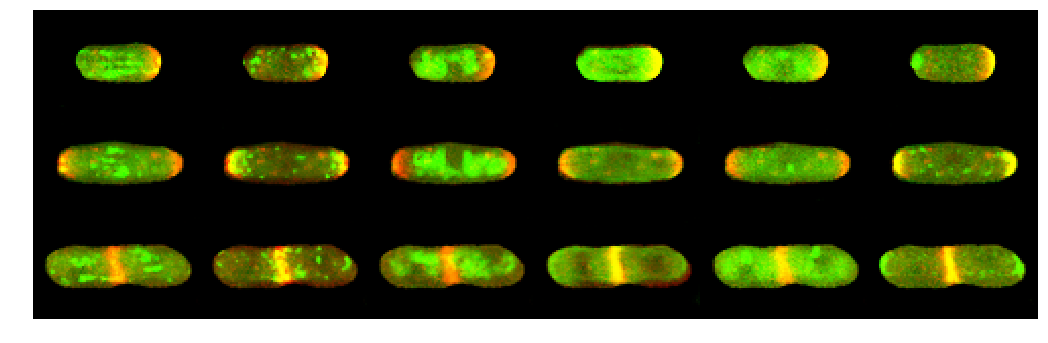

In [5]:
ids = torch.LongTensor([63, 43, 44])
show_cell_images(images_01[:,ids,:,:,:])

In [6]:
great_cells = images_01[:,ids,:,:,:]
great_cells = great_cells.view(-1, great_cells.size(2), great_cells.size(3), great_cells.size(4))
great_cells = pad_channels(great_cells, 3, value=0)
vutils.save_image(great_cells, 'teaser_fake.png', nrow=ids.numel())

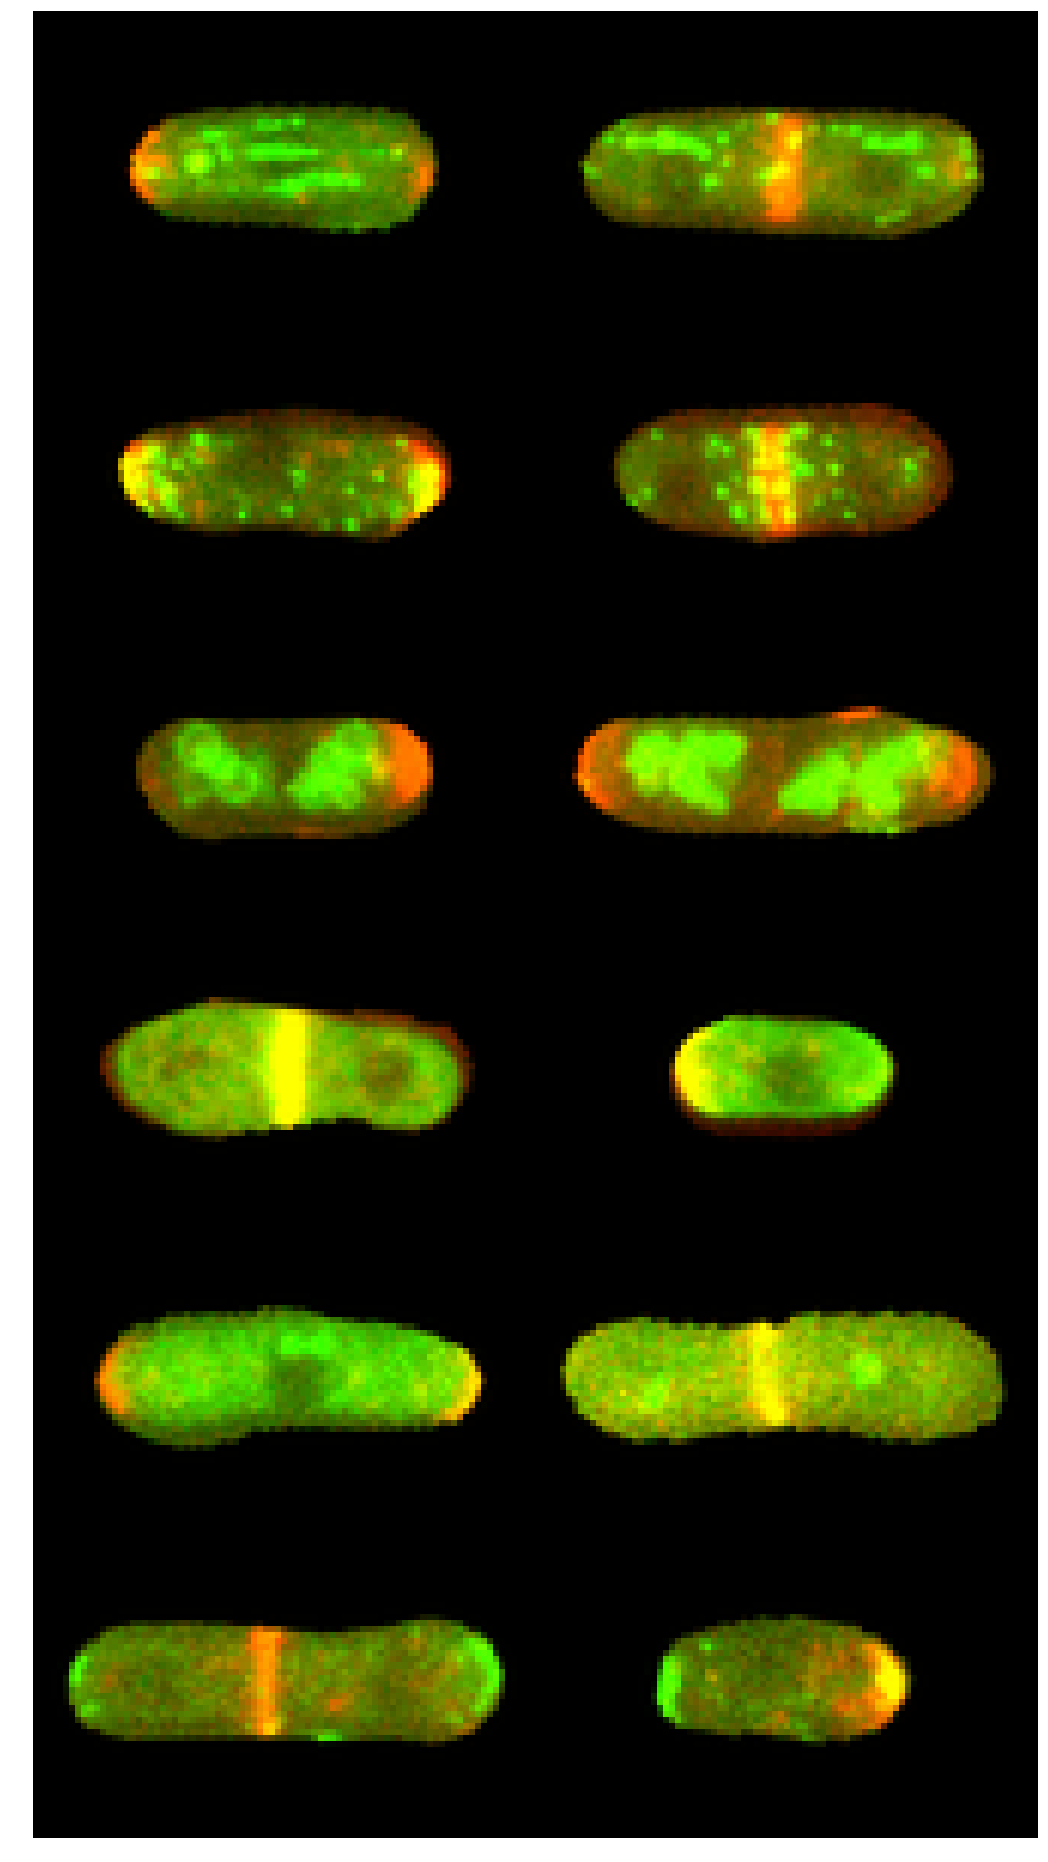

In [7]:
real_data_path = '../../data/LIN_Normalized_WT_size-48-80_6class_train'

real_cells=['Alp14/cell102579.png',
'Alp14/cell103136.png',
'Arp3/cell100057.png',
'Arp3/cell101184.png',
'Cki2/cell100230.png',
'Cki2/cell100595.png',
'Mkh1/cell100396.png',
'Mkh1/cell101451.png',
'Sid2/cell100191.png',
'Sid2/cell100925.png',
'Tea1/cell99959.png',
'Tea1/cell100414.png']

def show_real_images(images_01, ncols=8):
    images_01 = pad_channels(images_01, 3, value=0)
    grid = vutils.make_grid(images_01, nrow=ncols, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
    im = grid_to_image(grid)
    show_images(im)
    
cells = []
for cell_name in real_cells:
    cell_path = os.path.join(real_data_path, cell_name)
    img = read_image_for_pytorch(cell_path)
    img = torch.from_numpy(img.astype(np.float32)) / 255.0
    cells.append(img)
cells = torch.stack(cells, 0)
show_real_images(cells, ncols=2)
vutils.save_image(cells, 'teaser_real.png', nrow=2)